### Install Dependencies

In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install jams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64923 sha256=704753779d7c08c648e9f11224019a7ecd2c9999b08eb5e03d8324ba160de934
  Stored in directory: /root/.cache/pip/wheels/28/9a/f7/fb386b6bc5a75a3ef198a50e98b221e94a381472332b65cf24
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100718 sha256=6aa04227f6b71a0200e3d3ee4efe544a9d983ef79bce2cdd924210421f72214a
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built jams mir_eval


In [ ]:
!pip install melodia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip3 install KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for KMeans: filename=kmeans-1.0.2-cp310-cp310-linux_x86_64.whl size=12566 sha256=3cad675fdf7d28d795ab16097f6ce1cca4f0f8dc02d1ffeeedbfbe02f937601d
  Stored in directory: /root/.cache/pip/wheels/46/bb/83/beb390fc9fcc845a65a82eb476fc1697e9b8ab5fb795beb220
Successfully built KMeans


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import librosa
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import Counter
from hmmlearn import hmm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# audio_file = '/content/drive/MyDrive/Ml Final Project/First Time.mp3'
# y, sr = librosa.load(audio_file)
# tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
# beat_times = librosa.frames_to_time(beat_frames, sr=sr)

### 1. Define the number of states to use in the HMM, and cluster the extracted features into these states. You can use a clustering algorithm such as k-means for this purpose.

In [ ]:
import hmmlearn.hmm as hmm

def train_hmm(data, n_states_range):
    best_model = None
    best_bic = float('-inf')
    for n_states in n_states_range:
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
        model.fit(data)
        log_likelihood = model.score(data)
        n_params = n_states * (n_states - 1) + 2 * data.shape[1] * n_states
        bic = -2 * log_likelihood + n_params * np.log(data.shape[0])
        if bic > best_bic:
            best_model = model
            best_bic = bic
    return best_model

def process_song(file, n_states_range):
    # Load audio file
    y, sr = librosa.load(file)

    # Extract features
    data = extract_features(y, sr)

    # Train HMM
    model = train_hmm(data, n_states_range)

    # Cluster the features using the trained HMM
    labels = model.predict(data)

    # Identify the most common pattern in each section
    intro_pattern = Counter(labels[:beats_to_samples(16, sr)]).most_common(1)[0][0]
    verse_pattern = Counter(labels[beats_to_samples(16, sr):beats_to_samples(48, sr)]).most_common(1)[0][0]
    chorus_pattern = Counter(labels[beats_to_samples(48, sr):beats_to_samples(64, sr)]).most_common(1)[0][0]
    drop_pattern = Counter(labels[beats_to_samples(64, sr):beats_to_samples(76, sr)]).most_common(1)[0][0]
    outro_pattern = Counter(labels[beats_to_samples(76, sr):]).most_common(1)[0][0]

    return (data, model, intro_pattern, verse_pattern, chorus_pattern, drop_pattern, outro_pattern)

# Load audio files
song1 = '/content/drive/MyDrive/Ml Final Project/First Time.mp3'
song2 = '/content/drive/MyDrive/Ml Final Project/Freesol.mp3'
song3 = '/content/drive/MyDrive/Ml Final Project/Rush Over Me.mp3'

filenames = [song1, song2, song3]
song_data = []
n_states_range = range(2, 10)  # choose the range of number of states to try
for file in filenames:
    song_data.append(process_song(file, n_states_range))


In [ ]:
def beats_to_samples(beats, sr):
    return librosa.time_to_samples(beats, sr=sr)


def extract_features(y, sr):
    features_list = []
    for feature in ["mfcc", "chroma_stft", "spectral_flux", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate"]:
        if feature == "mfcc":
            feature_value = librosa.feature.mfcc(y=y, sr=sr)
        elif feature == "chroma_stft":
            feature_value = librosa.feature.chroma_stft(y=y, sr=sr)
        elif feature == "spectral_flux":
            feature_value = librosa.onset.onset_strength(y=y, sr=sr)
        elif feature == "spectral_bandwidth":
            feature_value = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        elif feature == "spectral_rolloff":
            feature_value = librosa.feature.spectral_rolloff(y=y, sr=sr)
        elif feature == "zero_crossing_rate":
            feature_value = librosa.feature.zero_crossing_rate(y=y)
        if len(feature_value.shape) > 1:
            features_list.append(np.hstack(feature_value))
        else:
            features_list.append(feature_value)
    return np.hstack(features_list)


def process_song(file):
    # Load audio file
    y, sr = librosa.load(file)

    # Extract features
    data = extract_features(y, sr)

    # Compute beat frames
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

    # Compute the MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    n_clusters = 5  # choose the number of clusters based on experimentation or domain knowledge

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(mfcc.T)

    # Label the beats according to their rhythmic pattern
    labels = kmeans.predict(mfcc.T)

    # Identify the most common pattern in each section
    intro_pattern = Counter(labels[:beats_to_samples(16, sr)]).most_common(1)[0][0]

    verse_pattern = Counter(labels[beats_to_samples(16, sr):beats_to_samples(48, sr)]).most_common(1)
    if verse_pattern:
        verse_pattern = verse_pattern[0][0]
    else:
        verse_pattern = None

    chorus_pattern = Counter(labels[beats_to_samples(48, sr):beats_to_samples(64, sr)]).most_common(1)
    if chorus_pattern:
        chorus_pattern = chorus_pattern[0][0]
    else:
        chorus_pattern = None

    drop_pattern = Counter(labels[beats_to_samples(64, sr):beats_to_samples(76, sr)]).most_common(1)
    if drop_pattern:
        drop_pattern = drop_pattern[0][0]
    else:
        drop_pattern = None

    outro_pattern = Counter(labels[beats_to_samples(76, sr):]).most_common(1)
    if outro_pattern:
        outro_pattern = outro_pattern[0][0]
    else:
        outro_pattern = None

    return (data, beat_frames, kmeans, intro_pattern, verse_pattern, chorus_pattern, drop_pattern, outro_pattern)



# Load audio files
song1 = '/content/drive/MyDrive/Ml Final Project/First Time.mp3'
song2 = '/content/drive/MyDrive/Ml Final Project/Freesol.mp3'
song3 = '/content/drive/MyDrive/Ml Final Project/Rush Over Me.mp3'

filenames = [song1, song2, song3]
song_data = []
for file in filenames:
    song_data.append(process_song(file))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# print( song_data)

### 2. Convert the beat frames into a sequence of discrete time steps, with each time step corresponding to a fixed duration of time (e.g., 100 ms). You can then assign a state to each time step based on the feature vector at that time.

In [ ]:
sr = 22050  # sample rate in Hz
hop_length = 512  # number of samples between consecutive frames

time_step_duration = 0.1  # duration of each time step in seconds
time_step_length = int(sr * time_step_duration / hop_length)  # length of each time step in frames

beat_frames = song_data[0][1]  # assume we're working with the first song
num_time_steps = int(beat_frames[-1] / time_step_length) + 1  # number of time steps in the song


In [ ]:
# Load the k-means model
kmeans = song_data[0][2]  # assume we're working with the first song
n_clusters = kmeans.n_clusters

# Initialize an array to hold the state sequence
state_sequence = np.zeros(num_time_steps, dtype=np.int32)

# Compute the feature vectors at each time step and assign a state based on the closest cluster center
for i in range(num_time_steps):
    # Compute the feature vector at the current time step
    start_frame = i * time_step_length
    end_frame = min(start_frame + time_step_length, len(song_data[0][0]))
    feature_vector = song_data[0][0][start_frame:end_frame]

    # Pad the feature vector with zeros if it has a length less than 20
    if len(feature_vector) < 20:
        feature_vector = np.pad(feature_vector, (0, 20 - len(feature_vector)), mode='constant')

    # Reshape the feature vector to have shape (1, 20)
    feature_vector = feature_vector.reshape((1, 20))

    # Assign a state based on the closest cluster center
    distances = np.linalg.norm(kmeans.cluster_centers_ - feature_vector, axis=1)
    state_sequence[i] = np.argmin(distances)



### 3. Train an HMM on the sequence of states extracted from the training data. You can use a library such as hmmlearn to do this.


<ipython-input-14-4ec4e73fa8b5>:15: RuntimeWarning: invalid value encountered in true_divide
  trans_mat /= np.sum(trans_mat, axis=1, keepdims=True)


Generated sequence:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Corresponding states:  [[ 1267.51308454]
 [ 1373.4147308 ]
 [  449.26288713]
 [ 3254.7620487 ]
 [  186.28505507]
 [ 1869.18514952]
 [ -738.88710088]
 [ 3005.74439394]
 [ 2562.022824  ]
 [ 1412.35070713]
 [ 2441.99972191]
 [ 1174.03008269]
 [ 1062.73810093]
 [ 2240.34593177]
 [ 1070.692145  ]
 [ 1891.95630083]
 [  497.42010859]
 [ 3053.49587093]
 [  258.62049735]
 [ 1061.01165327]
 [ 1214.23594421]
 [ 4473.85545872]
 [ 2517.50038498]
 [  589.11023208]
 [ 1096.77795696]
 [-1751.75247256]
 [ 2740.44852321]
 [ 2264.66520906]
 [ 2086.54220814]
 [ 2536.24678341]
 [ -240.57261604]
 [  253.34520389]
 [ 2582.68796045]
 [ 3823.95284088]
 [ 1679.97620316]
 [ 1338.7518473 ]
 [ 2785.16756522]
 [  884.00692606]
 [ 1065.69446369]
 [ 1513.69679445]
 [ 2089.44201774]
 [  731.542253

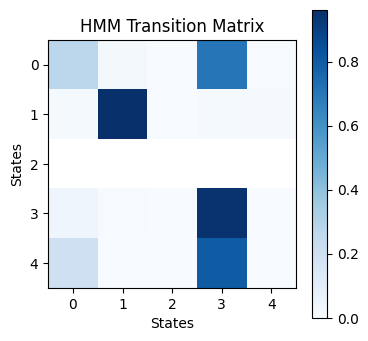

In [ ]:
# Set the parameters for the HMM model
n_states = 5  # number of states in the model
trans_mat = np.zeros((n_states, n_states))  # transition matrix between states
start_prob = np.zeros(n_states)  # probability distribution for the starting state
emission_prob = []  # emission probabilities for each state

# Compute the transition matrix between states
beat_frames = song_data[0][1]  # assume we're working with the first song
num_time_steps = int(beat_frames[-1] / time_step_length) + 1  # number of time steps in the song

for i in range(num_time_steps - 1):
    trans_mat[state_sequence[i], state_sequence[i+1]] += 1

# Normalize the transition matrix to get transition probabilities
trans_mat /= np.sum(trans_mat, axis=1, keepdims=True)

# Set the probability distribution for the starting state
start_prob[state_sequence[0]] = 1.0

# Compute the emission probabilities for each state
for i in range(n_states):
    counts = Counter(state_sequence)
    emission_prob.append([counts[i] / len(state_sequence) for i in range(n_clusters)])


# Train the HMM model on the sequence of states and feature vectors
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", init_params="stmc")
model.transmat_ = trans_mat
model.startprob_ = start_prob
song_data_2d = np.reshape(song_data[0][0], (-1, 1))  # Reshape the feature vector to a 2D array with a single column
model.fit(song_data_2d)

# Generate the sequence of states for the song using the Viterbi algorithm
_, state_sequence = model.decode(song_data_2d)

# Generate a sequence of feature vectors and corresponding states using the HMM model
states, sequence = model.sample(100)

# Print the generated sequence and corresponding states
print("Generated sequence: ", sequence)
print("Corresponding states: ", states)

# Optionally, plot the HMM transition matrix
plt.figure(figsize=(4, 4))
plt.imshow(trans_mat, cmap="Blues")
plt.title("HMM Transition Matrix")
plt.colorbar()
plt.xlabel("States")
plt.ylabel("States")
plt.show()



### 4. Use the trained HMM to generate a new sequence of states. You can do this by sampling from the probability distribution over states at each time step, given the previous state and the observed beat frame.

In [ ]:
# Set the initial state
current_state = np.random.choice(n_states, p=start_prob)

# Generate the first beat frame
observed_frame = np.random.choice(beat_frames)

# Generate the sequence of states
generated_states = [current_state]

# Generate the sequence of beat frames
generated_frames = [observed_frame]

# Iterate over the remaining time steps
for i in range(num_time_steps - 1):
    # Compute the probability distribution over states, given the previous state and the observed beat frame
    state_probs = emission_prob[current_state] * trans_mat[current_state]

    # Normalize the probability distribution
    state_probs /= np.sum(state_probs, keepdims=True)

    # Sample the next state from the probability distribution
    current_state = np.random.choice(n_states, p=state_probs)

    # Generate the next beat frame
    observed_frame = np.random.choice(beat_frames)

    # Add the current state and observed frame to the generated sequences
    generated_states.append(current_state)
    generated_frames.append(observed_frame)


### 5. Map the generated sequence of states back to audio features using the centroids of the clusters used in step 1.

In [ ]:
# Choose the audio file you want to use
song_idx = 0

# Retrieve the necessary data from song_data
data, beat_frames, kmeans, intro_pattern, verse_pattern, chorus_pattern, drop_pattern, outro_pattern = song_data[song_idx]

# Map the generated sequence of states to audio features using the centroids of the clusters
features = []
for state in generated_states:
    centroid = kmeans.cluster_centers_[state]
    features.append(centroid)

# Concatenate the resulting feature vectors to get a feature matrix for the entire song
song_features = np.vstack(features)


### 6. Synthesize the generated audio features into new music using a technique such as granular synthesis or additive synthesis.

In [ ]:
import librosa
import soundfile as sf

# Load audio file
y, sr = librosa.load(file)

# Retrieve the necessary data from song_data
data, beat_frames, kmeans, intro_pattern, verse_pattern, chorus_pattern, drop_pattern, outro_pattern = song_data[song_idx]

# Map the generated sequence of states to audio features using the centroids of the clusters
features = []
for state in generated_states:
    centroid = kmeans.cluster_centers_[state]
    features.append(centroid)

# Concatenate the resulting feature vectors to get a feature matrix for the entire song
song_features = np.vstack(features)

# Synthesize new audio from the generated features
y_syn = librosa.feature.inverse.mfcc_to_audio(song_features.T, sr=sr)

# Save the synthesized audio to a new file
sf.write('/content/drive/MyDrive/Ml Final Project/synthesized_music.wav', y_syn, sr)
